# load dataset

In [1]:
import os
data_dir = 'E:\\Datasets'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname, encoding='utf-8')
data = f.read()
f.close()

In [3]:
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


### Parsing the data

In [9]:
import numpy as np

float_data = np.zeros((len(lines), len(header)-1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values
    
print(float_data[0])

[  9.96520000e+02  -8.02000000e+00   2.65400000e+02  -8.90000000e+00
   9.33000000e+01   3.33000000e+00   3.11000000e+00   2.20000000e-01
   1.94000000e+00   3.12000000e+00   1.30775000e+03   1.03000000e+00
   1.75000000e+00   1.52300000e+02]


In [10]:
float_data.shape

(420551, 14)

### Plotting the temperature timeseries

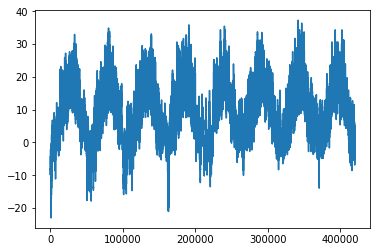

In [14]:
from matplotlib import pyplot as plt
%matplotlib inline

temp = float_data[:, 1] 
plt.plot(range(len(temp)), temp)

### Plotting the first 10 days of the temperature timeseries
Because the data is recorded every 10 minutes, you get 144 data points per day

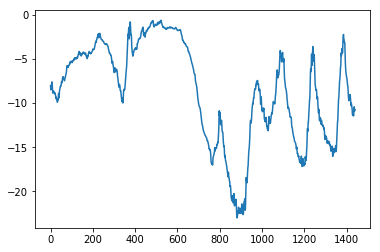

In [15]:
plt.plot(range(1440), temp[:1440])

# Data preprocessing
Preprocess the data to a format a neural network can ingest. This is easy: the
data is already numerical, so you don’t need to do any vectorization. But each
timeseries in the data is on a different scale (for example, temperature is typically between -20 and +30, but atmospheric pressure, measured in mbar, is
around 1,000). You’ll normalize each timeseries independently so that they all
take small values on a similar scale

In [18]:
mean = float_data[:200000].mean(axis=0)

In [19]:
mean

array([  988.88635885,     9.07734895,   283.14631345,     4.44854725,
          75.35405895,    13.3829553 ,     9.29695535,     4.08591725,
           5.8752111 ,     9.40521005,  1217.51429655,     2.1510037 ,
           3.56950915,   176.21703355])

In [20]:
float_data -= mean

In [21]:
std = float_data[:200000].std(axis=0)
std

array([  8.48043388,   8.85249908,   8.95324185,   7.16584991,
        16.72731652,   7.68914559,   4.19808168,   4.84034436,
         2.66564926,   4.25206364,  42.48884277,   1.53666449,
         2.33067298,  86.61322998])

In [22]:
float_data /= std

In [23]:
float_data[0]

array([ 0.90014748, -1.93135845, -1.98211036, -1.86280029,  1.07285236,
       -1.30742164, -1.47375773, -0.79868641, -1.4762674 , -1.47815522,
        2.12375056, -0.72950452, -0.78067973, -0.27613603])

# Data generator

In [24]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size = 128, step = 6):
    """
    data : The original array of floating-point data, which you normalized in listing 6.32.
    lookback : How many timesteps back the input data should go.
    delay : How many timesteps in the future the target should be.
    min_index and max_index : Indices in the data array that delimit which timesteps to draw from. This is useful for keeping a segment of the data for validation and another for testing.    shuffle—Whether to shuffle the samples or draw them in chronological order.
    batch_size : The number of samples per batch.
    step : The period, in timesteps, at which you sample data. You’ll set it to 6 in order to draw one data point every hour
    """
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    
    while 1:
        if shuffle:
            rows = np.random.randint(min_index+lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i+batch_size, max_index))
            i += len(rows)
            
        
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        
        yield samples, targets    

# Preparing the training, validation, and test generators

In [25]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data, lookback=lookback, delay=delay, min_index=0, max_index=200000, shuffle=True, step=step, batch_size=batch_size)
val_gen = generator(float_data, lookback=lookback, delay=delay, min_index=200001, max_index=300000, step=step, batch_size=batch_size)
test_gen = generator(float_data, lookback=lookback, delay=delay, min_index=300001, max_index=None, step=step, batch_size=batch_size)

In [26]:
val_steps = (300000 - 200001 - lookback)
test_steps = (len(float_data) - 300001 - lookback)

# Observation on Training and evaluating a densly connected model

In [27]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

Using TensorFlow backend.


In [31]:
model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=250)

Epoch 1/20
500/500 [==============================] - 6s - loss: 0.2710 - val_loss: 0.3045
Epoch 2/20
500/500 [==============================] - 5s - loss: 0.2564 - val_loss: 0.3261
Epoch 3/20
500/500 [==============================] - 5s - loss: 0.2450 - val_loss: 0.3283
Epoch 4/20
500/500 [==============================] - 5s - loss: 0.2394 - val_loss: 0.3142
Epoch 5/20
500/500 [==============================] - 5s - loss: 0.2323 - val_loss: 0.3284
Epoch 6/20
500/500 [==============================] - 6s - loss: 0.2275 - val_loss: 0.3324
Epoch 7/20
500/500 [==============================] - 6s - loss: 0.2243 - val_loss: 0.3179
Epoch 8/20
500/500 [==============================] - 6s - loss: 0.2209 - val_loss: 0.3294
Epoch 9/20
500/500 [==============================] - 6s - loss: 0.2164 - val_loss: 0.3398
Epoch 10/20
500/500 [==============================] - 6s - loss: 0.2127 - val_loss: 0.3280
Epoch 11/20
500/500 [==============================] - 6s - loss: 0.2115 - val_loss: 0.33

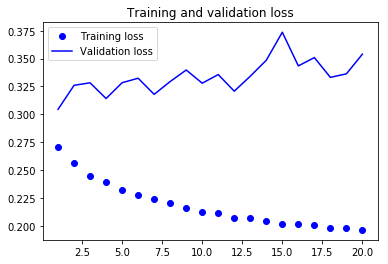

In [32]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=250)

Epoch 1/20
500/500 [==============================] - 108s - loss: 0.3023 - val_loss: 0.2637
Epoch 2/20
500/500 [==============================] - 107s - loss: 0.2850 - val_loss: 0.2817
Epoch 3/20
500/500 [==============================] - 108s - loss: 0.2773 - val_loss: 0.2874
Epoch 4/20
500/500 [==============================] - 113s - loss: 0.2747 - val_loss: 0.2527
Epoch 5/20
500/500 [==============================] - 110s - loss: 0.2711 - val_loss: 0.2537
Epoch 6/20
500/500 [==============================] - 108s - loss: 0.2651 - val_loss: 0.2959
Epoch 7/20
500/500 [==============================] - 107s - loss: 0.2598 - val_loss: 0.2570
Epoch 8/20
500/500 [==============================] - 109s - loss: 0.2577 - val_loss: 0.2575
Epoch 9/20
121/500 [======>.......................] - ETA: 78s - loss: 0.2551